In [1]:
#using Distributed
#@everywhere using MambaModels
using MambaModels
gr(size=(400,400))

# Data
line = Dict{Symbol, Any}()

howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [2]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight])
df2[:weight_c] = convert(Vector{Float64}, df2[:weight]) .- mean_weight ;
line[:x] = convert(Array{Float64,1}, df2[:weight_c]);
line[:y] = convert(Array{Float64,1}, df2[:height]);
line[:xmat] = convert(Array{Float64,2}, [ones(length(line[:x])) line[:x]])

352×2 Array{Float64,2}:
 1.0    2.83512
 1.0   -8.50468
 1.0  -13.1256 
 1.0    8.05143
 1.0   -3.71361
 1.0   18.0021 
 1.0   -6.74701
 1.0   10.4895 
 1.0  -10.1206 
 1.0    9.49725
 ⋮             
 1.0    2.89182
 1.0   -5.58468
 1.0   -3.94041
 1.0   -4.16721
 1.0    2.04133
 1.0  -10.7443 
 1.0    7.17259
 1.0    9.07201
 1.0    7.54114

Model Specification

In [3]:
model = Model(
  y = Stochastic(1,
    (xmat, beta, s2) -> MvNormal(xmat * beta, sqrt(s2)),
    false
  ),
  beta = Stochastic(1, () -> MvNormal([178, 0], [sqrt(10000), sqrt(100)])),
  s2 = Stochastic(() -> Uniform(0, 50))
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


Initial Values

In [4]:
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],
    :beta => [rand(Normal(178, 100)), rand(Normal(0, 10))],
    :s2 => rand(Uniform(0, 50))
  )
  for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[201.504, -12.0572],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>7.85086)  
 Dict(:beta=>[179.232, -13.5861],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>0.092289) 
 Dict(:beta=>[191.913, -0.0491609],:y=>[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75],:s2=>7.07135)

Tuning Parameters

In [5]:
scale1 = [0.5, 0.25]
summary1 = identity
eps1 = 0.5

scale2 = 0.5
summary2 = x -> [mean(x); sqrt(var(x))]
eps2 = 0.1

0.1

Define sampling scheme

In [6]:
scheme = [
  Mamba.NUTS([:beta]),
  Mamba.Slice([:s2], 10)
]

setsamplers!(model, scheme)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


MCMC Simulation

In [7]:
chn = mcmc(model, line, inits, 10000, burnin=1000, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:12:10 of 0:12:11 remaining]
Chain 1:  10% [0:00:10 of 0:00:11 remaining]
Chain 1:  20% [0:00:06 of 0:00:08 remaining]
Chain 1:  30% [0:00:05 of 0:00:07 remaining]
Chain 1:  40% [0:00:04 of 0:00:06 remaining]
Chain 1:  50% [0:00:03 of 0:00:06 remaining]
Chain 1:  60% [0:00:02 of 0:00:05 remaining]
Chain 1:  70% [0:00:02 of 0:00:05 remaining]
Chain 1:  80% [0:00:01 of 0:00:05 remaining]
Chain 1:  90% [0:00:00 of 0:00:05 remaining]
Chain 1: 100% [0:00:00 of 0:00:05 remaining]

Chain 2:   0% [0:00:02 of 0:00:02 remaining]
Chain 2:  10% [0:00:03 of 0:00:04 remaining]
Chain 2:  20% [0:00:03 of 0:00:04 remaining]
Chain 2:  30% [0:00:03 of 0:00:04 remaining]
Chain 2:  40% [0:00:02 of 0:00:04 remaining]
Chain 2:  50% [0:00:02 of 0:00:04 remaining]
Chain 2:  60% [0:00:02 of 0:00:04 remaining]
Chain 2:  70% [0:00:01 of 0:00:04 remaining]
Chain 2:  80% [0:00:01 of 0:00:04 remaining]
Chain 2:  90% [0:00:00 of 0:00:04 remaining]
Cha

Object of type "ModelChains"

Iterations = 1001:10000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 9000

[25.5706 154.613 0.931279; 28.284 154.402 0.906076; … ; 27.7004 154.231 0.893119; 25.5558 154.221 0.835464]

[25.5621 155.046 0.848843; 27.141 154.586 0.851142; … ; 26.7042 154.649 0.953289; 27.3536 154.306 0.947955]

[24.0507 154.555 0.935123; 24.6189 154.662 0.954478; … ; 25.909 154.669 0.906716; 24.3209 154.669 0.906716]

Show draws summary

In [8]:
describe(chn)

Iterations = 1001:10000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 9000

Empirical Posterior Estimates:
            Mean         SD        Naive SE        MCSE        ESS  
     s2  26.1887664 1.995319853 0.01214312992 0.01897211800 9000.000
beta[1] 154.5998700 0.275361656 0.00167579767 0.00398069252 4785.085
beta[2]   0.9054366 0.042124285 0.00025636023 0.00031790632 9000.000

Quantiles:
            2.5%        25.0%        50.0%       75.0%        97.5%   
     s2  22.60651227  24.7874759  26.10312599  27.4763059  30.42013761
beta[1] 154.05069158 154.4147351 154.60228582 154.7877814 155.13099793
beta[2]   0.82252635   0.8769556   0.90559395   0.9342771   0.98710956



Convert to MCMCChains.Chains object

In [9]:
chn2 = MCMCChains.Chains(chn.value, Symbol.(chn.names))

Object of type Chains, with data of type 9000×3×3 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:9000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3
Samples per chain = 9000
parameters        = s2, beta[1], beta[2]

parameters
          Mean     SD   Naive SE  MCSE     ESS  
beta[1] 154.5999 0.2754   0.0017 0.0040 4785.085
beta[2]   0.9054 0.0421   0.0003 0.0003 9000.000
     s2  26.1888 1.9953   0.0121 0.0190 9000.000



Describe the MCMCChains

In [10]:
MCMCChains.describe(chn2)

Log evidence      = 0.0
Iterations        = 1:9000
Thinning interval = 1
Chains            = Chain1, Chain2, Chain3
Samples per chain = 9000
parameters        = s2, beta[1], beta[2]

Empirical Posterior Estimates:
parameters
          Mean     SD   Naive SE  MCSE     ESS  
beta[1] 154.5999 0.2754   0.0017 0.0040 4785.085
beta[2]   0.9054 0.0421   0.0003 0.0003 9000.000
     s2  26.1888 1.9953   0.0121 0.0190 9000.000

Quantiles:
parameters
          2.5%     25.0%    50.0%    75.0%    97.5% 
beta[1] 153.5004 154.4147 154.6023 154.7878 155.5505
beta[2]   0.7426   0.8770   0.9056   0.9343   1.0750
     s2  19.6650  24.7875  26.1031  27.4763  36.4999



Plot chn2

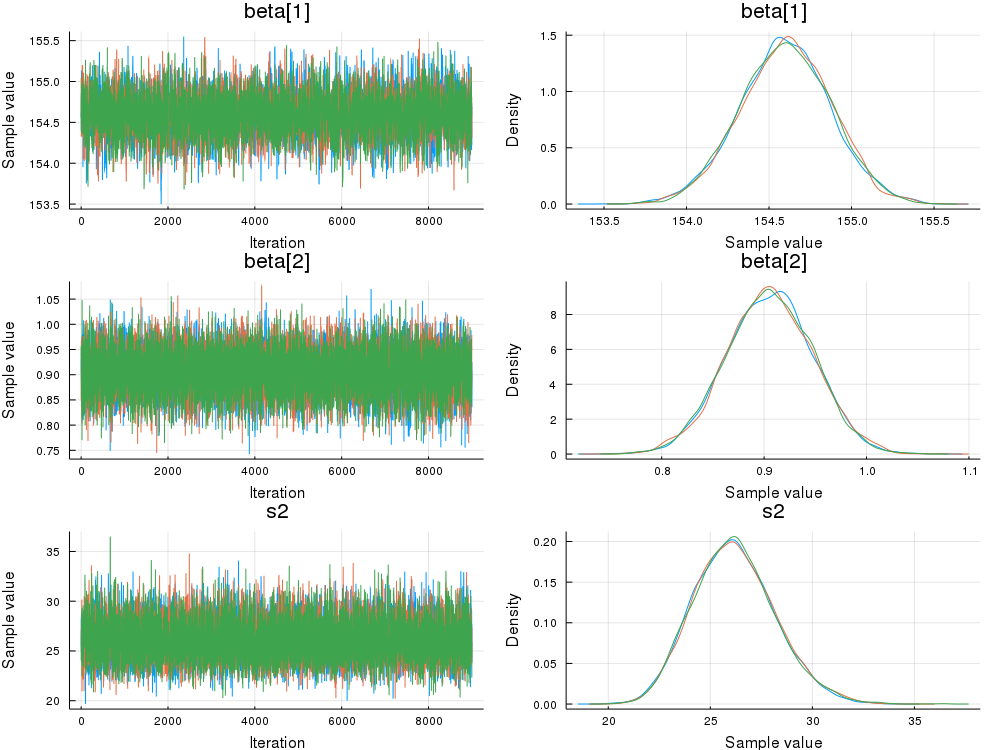

In [11]:
MCMCChains.plot(chn2)

End of `04/m4.1m.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*